In [342]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy import sparse 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Xây dựng mô hình

In [297]:
def softmax_stable(Z):
    """
    Sử dụng softmax_stable để tránh tràn số  
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def convert_labels(y, C):
    """
    Biến vector y thành ma trận one-hot
    """
    Y = sparse.coo_matrix((np.ones_like(y), 
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

def loss_function(X, Y, W):
    """
    Tính hàm mất mát cross-entropy loss
    """
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 50000):
    """
    Softmax Regression sử dụng Stochastic Gradient Descent (SGD)
    """
    W = [W_init]    
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]
    
    count = 0
    check_w_after = 20
    while count < max_count:
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # Điều kiện dừng
            if count%check_w_after == 0:                
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    """
    Dự đoán nhãn cho tập dữ liệu X
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

# Áp dụng vào bài toán

## 

## Chuẩn bị dữ liệu huấn luyện

In [298]:
df = pd.read_csv('data/obesity_data_cleaned.csv') 
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,1,0,...,0,0.000000,0.976473,1,0,0,0,1,0,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,2,0,...,0,1.000000,1.000000,0,1,0,0,0,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,1,0,...,0,0.866045,1.673584,0,0,0,0,1,0,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,1,0,...,0,1.467863,0.780199,1,0,0,0,1,0,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,1,0,...,0,1.967973,0.931721,1,0,0,0,1,0,6


In [299]:
# Lấy index dữ liệu liên tục
continuous_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
continuous_idx = [df.columns.get_loc(col) for col in continuous_cols]
continuous_idx

[1, 2, 3, 6, 7, 10, 12, 13]

In [300]:
# Chuẩn bị X,y thành np.arrays
X = df.drop('NObeyesdad', axis=1).values
# Thêm bias cho X
X = np.hstack([np.ones((X.shape[0], 1)), X])
y = df['NObeyesdad'].astype('category').cat.codes.values
X.shape, y.shape

((20758, 21), (20758,))

In [301]:
# Chia dữ liệu thành 3 tập train-test với tỷ lệ khác nhau
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=36, stratify=y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.3, random_state=36, stratify=y)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.4, random_state=36, stratify=y)

In [302]:
# Lấy index dữ liệu liên tục
continuous_idx_with_bias = [idx + 1 for idx in continuous_idx]  # +1 vì có bias ở đầu

## Kịch bản 1 (train/test = 4/1)

### Dự đoán với dữ liệu gốc

In [303]:
# Chuẩn hóa dữ liệu với các trường liên tục
scaler = StandardScaler()

X_train_1[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_1[:, continuous_idx_with_bias])
X_test_1[:, continuous_idx_with_bias] = scaler.transform(X_test_1[:, continuous_idx_with_bias])


In [331]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1 = pred(W_final, X_test_1.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       505
           1       0.77      0.82      0.79       617
           2       0.82      0.78      0.80       582
           3       0.90      0.97      0.93       650
           4       0.99      1.00      1.00       809
           5       0.75      0.43      0.55       485
           6       0.62      0.74      0.67       504

    accuracy                           0.83      4152
   macro avg       0.81      0.81      0.80      4152
weighted avg       0.83      0.83      0.82      4152



### PCA về 4 chiều

In [305]:
pca = PCA(n_components=4)
X_train_1_pca = pca.fit_transform(X_train_1[:, continuous_idx_with_bias])
X_test_1_pca = pca.transform(X_test_1[:, continuous_idx_with_bias])
X_train_1_pca.shape, X_test_1_pca.shape

((16606, 4), (4152, 4))

In [306]:
X_train_1_pca = np.hstack([np.ones((X_train_1_pca.shape[0], 1)), X_train_1_pca])
X_test_1_pca = np.hstack([np.ones((X_test_1_pca.shape[0], 1)), X_test_1_pca])
X_train_1_pca.shape, X_test_1_pca.shape

((16606, 5), (4152, 5))

In [307]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1_pca.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1_pca.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_pca = pred(W_final, X_test_1_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.81      0.57       505
           1       0.30      0.24      0.27       617
           2       0.39      0.47      0.42       582
           3       0.72      0.74      0.73       650
           4       0.85      0.96      0.91       809
           5       0.31      0.04      0.07       485
           6       0.23      0.18      0.20       504

    accuracy                           0.53      4152
   macro avg       0.46      0.49      0.45      4152
weighted avg       0.50      0.53      0.49      4152



### LDA về 4 chiều

In [308]:
lda = LDA(n_components=4)
X_train_1_lda = lda.fit_transform(X_train_1[:, continuous_idx_with_bias], y_train_1)
X_test_1_lda = lda.transform(X_test_1[:, continuous_idx_with_bias])
X_train_1_lda.shape, X_test_1_lda.shape

((16606, 4), (4152, 4))

In [309]:
X_train_1_lda = np.hstack([np.ones((X_train_1_lda.shape[0], 1)), X_train_1_lda])
X_test_1_lda = np.hstack([np.ones((X_test_1_lda.shape[0], 1)), X_test_1_lda])
X_train_1_lda.shape, X_test_1_lda.shape

((16606, 5), (4152, 5))

In [310]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1_lda.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_1_lda.T, y_train_1, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_lda = pred(W_final, X_test_1_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_1, y_pred_1_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       505
           1       0.78      0.78      0.78       617
           2       0.78      0.61      0.69       582
           3       0.86      0.95      0.90       650
           4       0.97      0.98      0.98       809
           5       0.64      0.56      0.60       485
           6       0.57      0.63      0.60       504

    accuracy                           0.80      4152
   macro avg       0.78      0.78      0.77      4152
weighted avg       0.79      0.80      0.79      4152



### LDA 4 chiều + dữ liệu category

In [311]:
# LDA 4 chiều cho biến liên tục
lda = LDA(n_components=4)
X_train_1_lda = lda.fit_transform(X_train_1[:, continuous_idx_with_bias], y_train_1)
X_test_1_lda = lda.transform(X_test_1[:, continuous_idx_with_bias])

# Lấy các biến categorical
categorical_idx = [i for i in range(X_train_1.shape[1]) 
                   if i != 0 and i not in continuous_idx_with_bias]
X_train_1_cat = X_train_1[:, categorical_idx]
X_test_1_cat = X_test_1[:, categorical_idx]

# Kết hợp: bias + LDA + categorical
bias_train = np.ones((X_train_1_lda.shape[0], 1))
bias_test = np.ones((X_test_1_lda.shape[0], 1))

X_train_1_lda_cat = np.hstack([bias_train, X_train_1_lda, X_train_1_cat])
X_test_1_lda_cat = np.hstack([bias_test, X_test_1_lda, X_test_1_cat])


In [312]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_1_lda_cat.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) * 0.01 # Khởi tạo nhỏ hơn

W = softmax_regression(X_train_1_lda_cat.T, y_train_1, W_init, eta=0.01)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_1_lda_cat = pred(W_final, X_test_1_lda_cat.T)

# Đánh giá mô hình
print(f"\nClassification Report (LDA 4D + Categorical):")
print(classification_report(y_test_1, y_pred_1_lda_cat))


Classification Report (LDA 4D + Categorical):
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       505
           1       0.76      0.78      0.77       617
           2       0.78      0.79      0.79       582
           3       0.91      0.96      0.93       650
           4       1.00      1.00      1.00       809
           5       0.62      0.71      0.66       485
           6       0.70      0.54      0.61       504

    accuracy                           0.82      4152
   macro avg       0.81      0.80      0.80      4152
weighted avg       0.82      0.82      0.82      4152



## Kịch bản 2 (train/test = 7/3)

### Dữ liệu gốc

In [313]:
# Chuẩn hóa
X_train_2[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_2[:, continuous_idx_with_bias])
X_test_2[:, continuous_idx_with_bias] = scaler.transform(X_test_2[:, continuous_idx_with_bias])

In [314]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2 = pred(W_final, X_test_2.T)

# Đánh giá mô hình
print(f"\nClassification Report kịch bản 2 + dữ liệu gốc:\n{classification_report(y_test_2, y_pred_2)}")


Classification Report kịch bản 2 + dữ liệu gốc:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       757
           1       0.76      0.82      0.79       925
           2       0.82      0.77      0.79       873
           3       0.88      0.97      0.92       974
           4       1.00      1.00      1.00      1214
           5       0.60      0.67      0.63       728
           6       0.70      0.53      0.60       757

    accuracy                           0.82      6228
   macro avg       0.81      0.80      0.80      6228
weighted avg       0.82      0.82      0.82      6228



### PCA về 4 chiều

In [315]:
pca = PCA(n_components=4)
X_train_2_pca = pca.fit_transform(X_train_2[:, continuous_idx_with_bias])
X_test_2_pca = pca.transform(X_test_2[:, continuous_idx_with_bias])
X_train_2_pca.shape, X_test_2_pca.shape

((14530, 4), (6228, 4))

In [316]:
X_train_2_pca = np.hstack([np.ones((X_train_2_pca.shape[0], 1)), X_train_2_pca])
X_test_2_pca = np.hstack([np.ones((X_test_2_pca.shape[0], 1)), X_test_2_pca])
X_train_2_pca.shape, X_test_2_pca.shape

((14530, 5), (6228, 5))

In [317]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2_pca.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2_pca.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_pca = pred(W_final, X_test_2_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_2, y_pred_2_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.55       757
           1       0.38      0.41      0.40       925
           2       0.53      0.31      0.39       873
           3       0.62      0.82      0.71       974
           4       0.85      0.97      0.91      1214
           5       0.26      0.10      0.14       728
           6       0.27      0.28      0.28       757

    accuracy                           0.55      6228
   macro avg       0.49      0.50      0.48      6228
weighted avg       0.52      0.55      0.52      6228



### LDA về 4 chiều

In [318]:
lda = LDA(n_components=4)
X_train_2_lda = lda.fit_transform(X_train_2[:, continuous_idx_with_bias], y_train_2)
X_test_2_lda = lda.transform(X_test_2[:, continuous_idx_with_bias])
X_train_2_lda.shape, X_test_2_lda.shape

((14530, 4), (6228, 4))

In [319]:
X_train_2_lda = np.hstack([np.ones((X_train_2_lda.shape[0], 1)), X_train_2_lda])
X_test_2_lda = np.hstack([np.ones((X_test_2_lda.shape[0], 1)), X_test_2_lda])
X_train_2_lda.shape, X_test_2_lda.shape

((14530, 5), (6228, 5))

In [320]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2_lda.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2_lda.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_lda = pred(W_final, X_test_2_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_2, y_pred_2_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       757
           1       0.79      0.76      0.77       925
           2       0.81      0.68      0.74       873
           3       0.84      0.96      0.89       974
           4       0.98      0.98      0.98      1214
           5       0.57      0.68      0.62       728
           6       0.63      0.47      0.54       757

    accuracy                           0.80      6228
   macro avg       0.78      0.78      0.77      6228
weighted avg       0.80      0.80      0.79      6228



In [321]:
# LDA 4 chiều cho biến liên tục
lda = LDA(n_components=4)
X_train_2_lda = lda.fit_transform(X_train_2[:, continuous_idx_with_bias], y_train_2)
X_test_2_lda = lda.transform(X_test_2[:, continuous_idx_with_bias])

# Lấy các biến categorical
categorical_idx = [i for i in range(X_train_2.shape[1]) 
                   if i != 0 and i not in continuous_idx_with_bias]
X_train_2_cat = X_train_2[:, categorical_idx]
X_test_2_cat = X_test_2[:, categorical_idx]

# Kết hợp: bias + LDA + categorical
bias_train = np.ones((X_train_2_lda.shape[0], 1))
bias_test = np.ones((X_test_2_lda.shape[0], 1))

X_train_2_lda_cat = np.hstack([bias_train, X_train_2_lda, X_train_2_cat])
X_test_2_lda_cat = np.hstack([bias_test, X_test_2_lda, X_test_2_cat])


In [322]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_2_lda_cat.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_2_lda_cat.T, y_train_2, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_2_lda_cat = pred(W_final, X_test_2_lda_cat.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_2, y_pred_2_lda_cat)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       757
           1       0.84      0.72      0.78       925
           2       0.84      0.67      0.75       873
           3       0.86      0.98      0.91       974
           4       1.00      1.00      1.00      1214
           5       0.62      0.72      0.67       728
           6       0.68      0.62      0.65       757

    accuracy                           0.82      6228
   macro avg       0.81      0.81      0.80      6228
weighted avg       0.83      0.82      0.82      6228



## Kịch bản 3 (train/test = 6/4)

### Dữ liệu gốc

In [323]:
# Chuẩn hóa
X_train_3[:, continuous_idx_with_bias] = scaler.fit_transform(X_train_3[:, continuous_idx_with_bias])
X_test_3[:, continuous_idx_with_bias] = scaler.transform(X_test_3[:, continuous_idx_with_bias])

In [324]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3.shape[1] # Số đặc trưng
C = len(np.unique(y)) # Số lớp
W_init = np.random.randn(d, C) # Khởi tạo trọng số ngẫu nhiên

W = softmax_regression(X_train_3.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3 = pred(W_final, X_test_3.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1009
           1       0.84      0.69      0.75      1233
           2       0.64      0.89      0.75      1164
           3       0.95      0.93      0.94      1299
           4       0.99      1.00      1.00      1619
           5       0.61      0.72      0.66       971
           6       0.75      0.36      0.48      1009

    accuracy                           0.81      8304
   macro avg       0.80      0.79      0.78      8304
weighted avg       0.82      0.81      0.80      8304



### PCA về 4 chiều

In [325]:
pca = PCA(n_components=4)
X_train_3_pca = pca.fit_transform(X_train_3[:, continuous_idx_with_bias])
X_test_3_pca = pca.transform(X_test_3[:, continuous_idx_with_bias])

X_train_3_pca = np.hstack([np.ones((X_train_3_pca.shape[0], 1)), X_train_3_pca])
X_test_3_pca = np.hstack([np.ones((X_test_3_pca.shape[0], 1)), X_test_3_pca])

In [326]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3_pca.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_pca.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_pca = pred(W_final, X_test_3_pca.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3_pca)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.31      0.42      1009
           1       0.37      0.66      0.48      1233
           2       0.56      0.15      0.24      1164
           3       0.66      0.82      0.73      1299
           4       0.87      0.97      0.91      1619
           5       0.23      0.24      0.24       971
           6       0.27      0.23      0.25      1009

    accuracy                           0.53      8304
   macro avg       0.51      0.48      0.47      8304
weighted avg       0.54      0.53      0.51      8304



### LDA về 4 chiều

In [327]:
lda = LDA(n_components=4)
X_train_3_lda = lda.fit_transform(X_train_3[:, continuous_idx_with_bias], y_train_3)
X_test_3_lda = lda.transform(X_test_3[:, continuous_idx_with_bias])
X_train_3_lda = np.hstack([np.ones((X_train_3_lda.shape[0], 1)), X_train_3_lda])
X_test_3_lda = np.hstack([np.ones((X_test_3_lda.shape[0], 1)), X_test_3_lda])

In [328]:
# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3_lda.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_lda.T, y_train_3, W_init, eta=0.05)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_lda = pred(W_final, X_test_3_lda.T)

# Đánh giá mô hình
print(f"\nClassification Report:\n{classification_report(y_test_3, y_pred_3_lda)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1009
           1       0.73      0.78      0.75      1233
           2       0.74      0.80      0.77      1164
           3       0.93      0.91      0.92      1299
           4       0.98      0.98      0.98      1619
           5       0.75      0.29      0.42       971
           6       0.56      0.71      0.63      1009

    accuracy                           0.80      8304
   macro avg       0.79      0.78      0.76      8304
weighted avg       0.80      0.80      0.79      8304



### LDA về 4 chiều + các trường category

In [339]:
# LDA 4 chiều cho biến liên tục
lda = LDA(n_components=4)
X_train_3_lda = lda.fit_transform(X_train_3[:, continuous_idx_with_bias], y_train_3)
X_test_3_lda = lda.transform(X_test_3[:, continuous_idx_with_bias])

# Lấy các biến categorical
categorical_idx = [i for i in range(X_train_3.shape[1]) 
                   if i != 0 and i not in continuous_idx_with_bias]
X_train_3_cat = X_train_3[:, categorical_idx]
X_test_3_cat = X_test_3[:, categorical_idx]

# Kết hợp: bias + LDA + categorical
bias_train = np.ones((X_train_3_lda.shape[0], 1))
bias_test = np.ones((X_test_3_lda.shape[0], 1))

X_train_3_lda_cat = np.hstack([bias_train, X_train_3_lda, X_train_3_cat])
X_test_3_lda_cat = np.hstack([bias_test, X_test_3_lda, X_test_3_cat])

# Khởi tạo tham số và huấn luyện mô hình
d = X_train_3_lda_cat.shape[1]
C = len(np.unique(y))
W_init = np.random.randn(d, C)

W = softmax_regression(X_train_3_lda_cat.T, y_train_3, W_init, eta=0.01)
W_final = W[-1]

# Dự đoán trên tập test
y_pred_3_lda_cat = pred(W_final, X_test_3_lda_cat.T)

# Đánh giá mô hình
print(f"\nClassification Report (LDA 4D + Categorical):")
print(classification_report(y_test_3, y_pred_3_lda_cat))


Classification Report (LDA 4D + Categorical):
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1009
           1       0.85      0.60      0.70      1233
           2       0.81      0.78      0.79      1164
           3       0.93      0.95      0.94      1299
           4       0.99      1.00      1.00      1619
           5       0.60      0.72      0.66       971
           6       0.68      0.65      0.67      1009

    accuracy                           0.82      8304
   macro avg       0.81      0.81      0.80      8304
weighted avg       0.83      0.82      0.82      8304



# Tổng hợp kết quả

In [340]:


# Tạo dictionary để lưu kết quả
results = {
    'Kịch bản 1 (80/20)': {
        'Dữ liệu gốc': {'y_true': y_test_1, 'y_pred': y_pred_1},
        'PCA 4D': {'y_true': y_test_1, 'y_pred': y_pred_1_pca},
        'LDA 4D': {'y_true': y_test_1, 'y_pred': y_pred_1_lda},
        'LDA 4D + Cat': {'y_true': y_test_1, 'y_pred': y_pred_1_lda_cat}
    },
    'Kịch bản 2 (70/30)': {
        'Dữ liệu gốc': {'y_true': y_test_2, 'y_pred': y_pred_2},
        'PCA 4D': {'y_true': y_test_2, 'y_pred': y_pred_2_pca},
        'LDA 4D': {'y_true': y_test_2, 'y_pred': y_pred_2_lda},
        'LDA 4D + Cat': {'y_true': y_test_2, 'y_pred': y_pred_2_lda_cat}
    },
    'Kịch bản 3 (60/40)': {
        'Dữ liệu gốc': {'y_true': y_test_3, 'y_pred': y_pred_3},
        'PCA 4D': {'y_true': y_test_3, 'y_pred': y_pred_3_pca},
        'LDA 4D': {'y_true': y_test_3, 'y_pred': y_pred_3_lda},
        'LDA 4D + Cat': {'y_true': y_test_3, 'y_pred': y_pred_3_lda_cat}
    }
}

# Tính toán metrics
summary_data = []
n_classes = len(np.unique(y))

for scenario, methods in results.items():
    for method, data in methods.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        
        # Binarize labels cho AUC calculation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        y_pred_bin = label_binarize(y_pred, classes=range(n_classes))
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(y_true_bin, y_pred_bin)
        
        summary_data.append({
            'Kịch bản': scenario,
            'Phương pháp': method,
            'Accuracy': f"{acc:.4f}",
            'Precision': f"{prec:.4f}",
            'Recall': f"{rec:.4f}",
            'F1-Score': f"{f1:.4f}",
            'AUC': f"{auc:.4f}"
        })

# Tạo DataFrame tổng hợp
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

          Kịch bản  Phương pháp Accuracy Precision Recall F1-Score    AUC
Kịch bản 1 (80/20)  Dữ liệu gốc   0.8297    0.8145 0.8089   0.8043 0.8904
Kịch bản 1 (80/20)       PCA 4D   0.5299    0.4633 0.4916   0.4531 0.7068
Kịch bản 1 (80/20)       LDA 4D   0.7955    0.7760 0.7762   0.7735 0.8713
Kịch bản 1 (80/20) LDA 4D + Cat   0.8220    0.8051 0.8027   0.8019 0.8867
Kịch bản 2 (70/30)  Dữ liệu gốc   0.8239    0.8061 0.8033   0.8020 0.8871
Kịch bản 2 (70/30)       PCA 4D   0.5454    0.4859 0.5040   0.4818 0.7142
Kịch bản 2 (70/30)       LDA 4D   0.7977    0.7781 0.7790   0.7742 0.8728
Kịch bản 2 (70/30) LDA 4D + Cat   0.8234    0.8076 0.8081   0.8041 0.8895
Kịch bản 3 (60/40)  Dữ liệu gốc   0.8071    0.7987 0.7873   0.7777 0.8778
Kịch bản 3 (60/40)       PCA 4D   0.5306    0.5146 0.4837   0.4665 0.7028
Kịch bản 3 (60/40)       LDA 4D   0.7989    0.7868 0.7765   0.7648 0.8717
Kịch bản 3 (60/40) LDA 4D + Cat   0.8223    0.8085 0.8096   0.8035 0.8902


## Ma trận nhầm lẫn với kịch bản tốt nhất

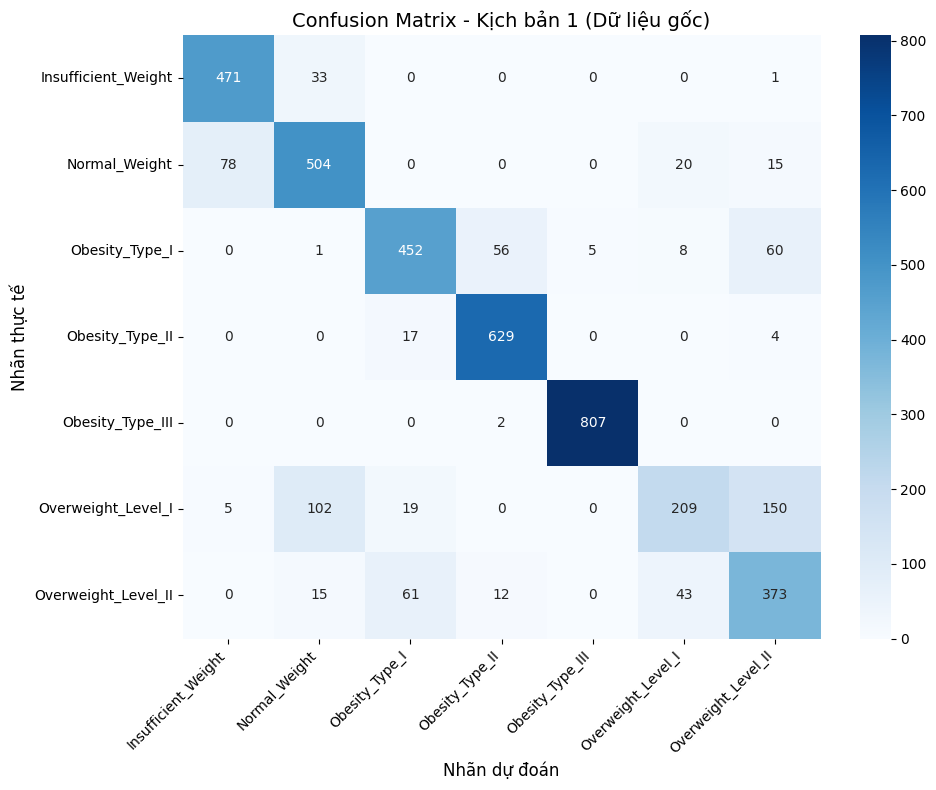

In [346]:
label_mapping = {
    0: 'Insufficient_Weight',
    1: 'Normal_Weight',
    2: 'Obesity_Type_I',
    3: 'Obesity_Type_II',
    4: 'Obesity_Type_III',
    5: 'Overweight_Level_I',
    6: 'Overweight_Level_II'
}

# Lấy danh sách tên nhãn theo thứ tự
labels = [label_mapping[i] for i in range(len(label_mapping))]

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test_1, y_pred_1)

# Vẽ ma trận nhầm lẫn với nhãn đầy đủ
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels, yticklabels=labels
)
plt.title('Confusion Matrix - Kịch bản 1 (Dữ liệu gốc)', fontsize=14)
plt.xlabel('Nhãn dự đoán', fontsize=12)
plt.ylabel('Nhãn thực tế', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()